In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

%matplotlib inline
plt.style.use('seaborn-whitegrid')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/CleanCrime.csv')

In [3]:
df.head()

,OFFENSE_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,REPORT_HOUR,REPORT_MONTH,REPORT_YEAR,REPORT_DAY
0,2016376978521300,5213,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,2016-06-15 23:31:00,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,23,6,2016,2
1,20186000994239900,2399,theft-other,larceny,10/11/2017 12:30:00 PM,2018-01-29 17:53:00,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,17,1,2018,0
2,20166003953230500,2305,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,2016-04-26 21:02:00,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,21,4,2016,1
3,201872333239900,2399,theft-other,larceny,1/30/2018 7:20:00 PM,2018-01-30 22:29:00,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,22,1,2018,1
4,2017411405230300,2303,theft-shoplift,larceny,6/22/2017 8:53:00 PM,2017-06-23 16:09:00,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,16,6,2017,4


In [4]:
#Set Reported date to a date time object and change format
df['REPORTED_DATE'] = pd.to_datetime(df['REPORTED_DATE'], infer_datetime_format=True)
df['REPORTED_DATE']= df['REPORTED_DATE'].dt.strftime('%Y/%m/%d')
df['REPORTED_DATE']= pd.to_datetime(df['REPORTED_DATE'])

In [5]:
# create a dataframe grouping public disorder, sexual assault and auto theft offense category into their own dataframes 
public = df[df['OFFENSE_CATEGORY_ID']=='public-disorder']
sex_assult = df[df['OFFENSE_CATEGORY_ID']=='sexual-assault']
auto_theft = df[df['OFFENSE_CATEGORY_ID']=='auto-theft']


In [6]:
#creating a dataframe for the Linear Regression with the date as the index and a total public disorders column 
#filling all NaNs with 0 also adding an alais column named tick column to preserve the timeseries for future use.
t = public['OFFENSE_CATEGORY_ID'].groupby([public.REPORTED_DATE, public.OFFENSE_TYPE_ID]).agg('count')
t = t.unstack(level=1)
t["total"] = t.sum(axis = 1, skipna = True)
t= t[:].fillna(value=0)
t['tick'] = range(0,len(t.index.values))
# t.head()

s = sex_assult['OFFENSE_CATEGORY_ID'].groupby([sex_assult.REPORTED_DATE, sex_assult.OFFENSE_TYPE_ID]).agg('count')
s = s.unstack(level=1)
s["total"] = s.sum(axis = 1, skipna = True)
s= s[:].fillna(value=0)
s['tick'] = range(0,len(s.index.values))


a = auto_theft['OFFENSE_CATEGORY_ID'].groupby([auto_theft.REPORTED_DATE, auto_theft.OFFENSE_TYPE_ID]).agg('count')
a = a.unstack(level=1)
a["total"] = a.sum(axis = 1, skipna = True)
a= a[:].fillna(value=0)
a['tick'] = range(0,len(a.index.values))


Text(0.5,1,'Public disorders')

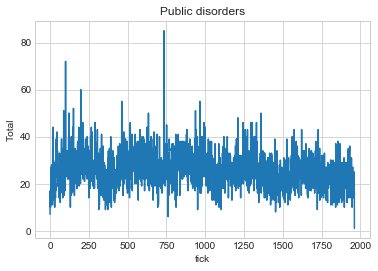

In [7]:

plt.plot('tick','total',data=t)
plt.xlabel('tick')
plt.ylabel('Total')
plt.title('Public disorders')


Text(0.5,1,'Sexual Assualt over Time')

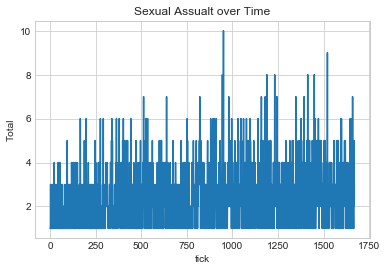

In [8]:
plt.plot('tick','total',data=s)
plt.xlabel('tick')
plt.ylabel('Total')
plt.title('Sexual Assualt over Time')

Text(0.5,1,'Auto Theft over time')

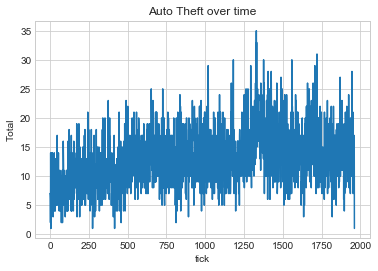

In [9]:
plt.plot('tick','total',data=a)
plt.xlabel('tick')
plt.ylabel('Total')
plt.title('Auto Theft over time')

Sampling data down to 1/10 its size and reorganizing data

In [10]:
#sampling down to 1/10th the size
one_tenth = t.sample(frac=.1, random_state=np.random.randint(10))
one_tenthAuto=a.sample(frac=.1, random_state=np.random.randint(10))
one_thethSexualAssualt = s.sample(frac=.1, random_state=np.random.randint(10))
#Reorder data 
one_tenth.index_name = None
one_tenth=one_tenth.sort_values(by=['tick'], ascending=True)
one_tenthAuto.index_name = None
one_tenthAuto=one_tenthAuto.sort_values(by=['tick'], ascending=True)
one_thethSexualAssualt.index_name = None
one_thethSexualAssualt=one_thethSexualAssualt.sort_values(by=['tick'], ascending=True)

Text(0,0.5,'Total')

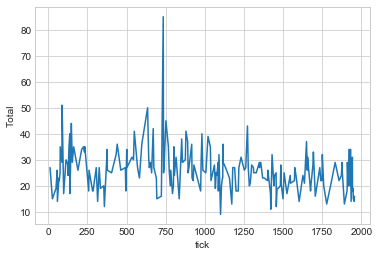

In [11]:
plt.plot('tick','total',data=one_tenth)
plt.xlabel('tick')
plt.ylabel('Total')

Text(0.5,1,'Sampled Total of Sexual Assualt')

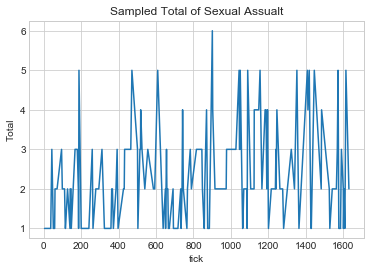

In [12]:
plt.plot('tick','total',data=one_thethSexualAssualt)
plt.xlabel('tick')
plt.ylabel('Total')
plt.title('Sampled Total of Sexual Assualt')

Text(0.5,1,'1/10th Sample of Auto Theft')

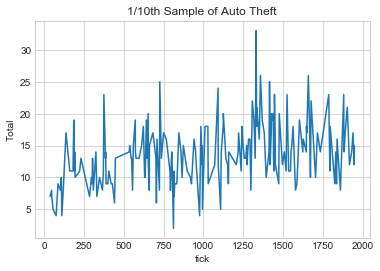

In [13]:
plt.plot('tick','total',data=one_tenthAuto)
plt.xlabel('tick')
plt.ylabel('Total')
plt.title('1/10th Sample of Auto Theft')

Text(0.5,1,'Sampled Plot')

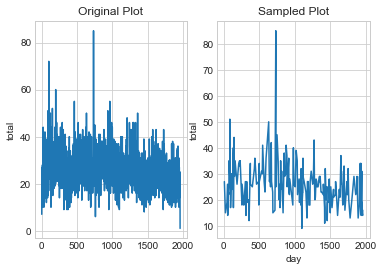

In [14]:
plt.subplot(1, 2, 1)
plt.plot('tick','total',data=t)
plt.title('day')
plt.ylabel('total')
plt.title('Original Plot')

plt.subplot(1, 2, 2)
plt.plot('tick','total',data=one_tenth)
plt.xlabel('day')
plt.ylabel('total')
plt.title('Sampled Plot')


In [15]:
#resetting index
t.reset_index(inplace=True)
a.reset_index(inplace=True)
s.reset_index(inplace=True)


In [16]:
t['RollingMean']=t['total'].rolling(window = 100).mean()
a['RollingMean']=a['total'].rolling(window = 100).mean()
s['RollingMean']=s['total'].rolling(window = 100).mean()

Text(0.5,1,'Roling Mean Plot')

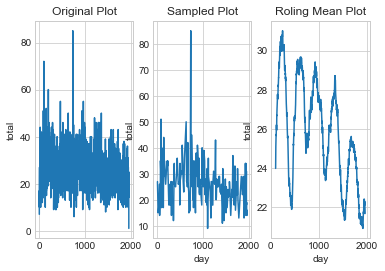

In [17]:
plt.subplot(1, 3, 1)
plt.plot('tick','total',data=t)
plt.title('day')
plt.ylabel('total')
plt.title('Original Plot')

plt.subplot(1, 3, 2)
plt.plot('tick','total',data=one_tenth)
plt.xlabel('day')
plt.ylabel('total')
plt.title('Sampled Plot')

plt.subplot(1, 3, 3)
plt.plot('tick','RollingMean',data=t)
plt.xlabel('day')
plt.ylabel('total')
plt.title('Roling Mean Plot')


Text(0.5,1,'Roling Mean of Sexual Assualt')

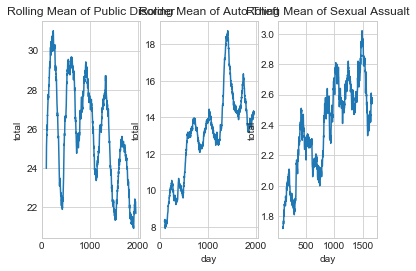

In [18]:
#Rolling means for all 3 categories

plt.subplot(1, 3, 1)
plt.plot('tick','RollingMean',data=t)
plt.title('day')
plt.ylabel('total')
plt.title('Rolling Mean of Public Disorder')

plt.subplot(1, 3, 2)
plt.plot('tick','RollingMean',data=a)
plt.xlabel('day')
plt.ylabel('total')
plt.title('Roling Mean of Auto-Theft')

plt.subplot(1, 3, 3)
plt.plot('tick','RollingMean',data=s)
plt.xlabel('day')
plt.ylabel('total')
plt.title('Roling Mean of Sexual Assualt')


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


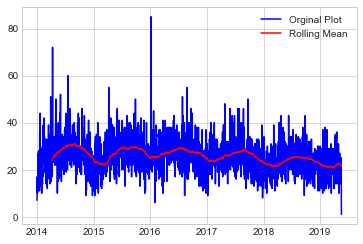

In [19]:
plt.plot(t.REPORTED_DATE, t.total, 'b-', label='Orginal Plot')
plt.plot(t.REPORTED_DATE, t.RollingMean, 'r-', label='Rolling Mean')
plt.legend(loc='best')


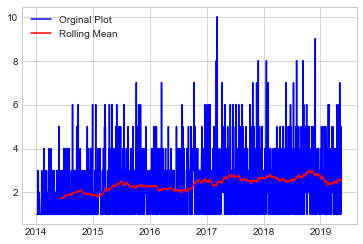

In [20]:
plt.plot(s.REPORTED_DATE, s.total, 'b-', label='Orginal Plot')
plt.plot(s.REPORTED_DATE, s.RollingMean, 'r-', label='Rolling Mean')
plt.legend(loc='best')


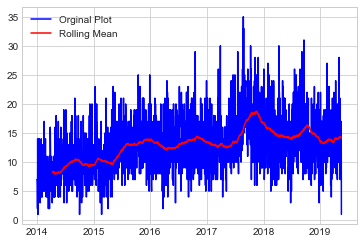

In [21]:
plt.plot(a.REPORTED_DATE, a.total, 'b-', label='Orginal Plot')
plt.plot(a.REPORTED_DATE, a.RollingMean, 'r-', label='Rolling Mean')
plt.legend(loc='best')


## Linear Regression - public-disorder

Cut down tfit to less data so we can predict more

In [22]:

#Filter out the NaNs from the Rolling Mean so Model can handle data
tfit = t[99:]
tfitTrain = t[:1304]
tfitTest = t[1305:]


model = LinearRegression().fit(tfit[['tick']], tfit[['RollingMean']])
m = model.coef_[0]
b = model.intercept_

model2 = LinearRegression().fit(t[['tick']], t[['total']])
m2 = model2.coef_[0]
b2 = model2.intercept_

In [23]:
print('model 1 => y = ', (m[0:2]), 'x + ', (b[0:2]))
print('model 2 => y = ', (m2[0:2]), 'x + ', (b2[0:2]))

model 1 => y =  [-0.00299674] x +  [28.95508724]
model 2 => y =  [-0.00262131] x +  [28.24553059]


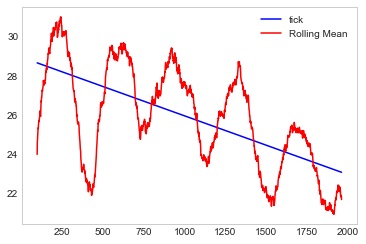

In [24]:

x = tfit.tick
y = m*x + b
plt.plot(x, y, '-b',)
plt.plot(tfit.tick, tfit.RollingMean, 'r-', label='Rolling Mean')
#Plotting LR vs Rolling Mean
plt.legend(loc='best')
plt.grid()
plt.show()

## Linear Regression - Sexual assault


In [25]:
sfit = s[99:]

model = LinearRegression().fit(sfit[['tick']], sfit[['RollingMean']])
sm = model.coef_[0]
sb = model.intercept_

model2 = LinearRegression().fit(s[['tick']], s[['total']])
sm2 = model2.coef_[0]
sb2 = model2.intercept_


In [26]:
print('model 1 => y = ', (sm[0:2]), 'x + ', (sb[0:2]))
print('model 2 => y = ', (sm2[0:2]), 'x + ', (sb2[0:2]))

model 1 => y =  [0.00052737] x +  [1.92147778]
model 2 => y =  [0.00054044] x +  [1.92145476]


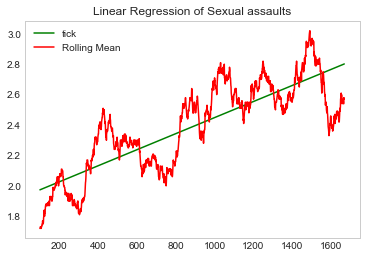

In [27]:
sx = sfit.tick
sy = sm*sx + sb
plt.plot(sx, sy, '-g',)
plt.plot(sfit.tick, sfit.RollingMean, 'r-', label='Rolling Mean')
#Plotting LR vs Rolling Mean
plt.legend(loc='best')
plt.title("Linear Regression of Sexual assaults")
plt.grid()
plt.show()

In [28]:
# use the equation of the line to get y values
predictions = model.predict(sfit[['tick']])
predictions

array([[1.97368783],
       [1.97421521],
       [1.97474258],
       ...,
       [2.8006107 ],
       [2.80113807],
       [2.80166544]])

## Long Short Term Memory (LSTM)

LSTM are used for sequence prediction problmes and are highly effective because they are able to store past information that is important and forget the info that is not. LSTM use three gates
* Input gate : Adds info to cell state
* Forget gate : Removes info that is no longer required
* Output gate : LSTM selects the info to be output

[Introduction to Long Short Term Memory](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)

In [29]:
data = t.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(t)),columns=['REPORTED_DATE', 'total'])
for i in range(0,len(data)):
    new_data['REPORTED_DATE'][i] = data['REPORTED_DATE'][i]
    new_data['total'][i] = data['total'][i]

In [30]:
#setting index
new_data.index = new_data.REPORTED_DATE
new_data.drop('REPORTED_DATE', axis=1, inplace=True)


In [31]:
#creating test and train sets
dataset = new_data.values
train = dataset[0:1169,:]
valid = dataset[1169:,:]

In [32]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=2, batch_size=2, verbose=3)

#predicting values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
crime_pred = model.predict(X_test)
crime_pred = scaler.inverse_transform(crime_pred)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
Epoch 2/2


Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. It tells you how concentrated the data is around the line of best fit. 

In [34]:
rms=np.sqrt(np.mean(np.power((valid-crime_pred),2)))
rms

8.395833132644748

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


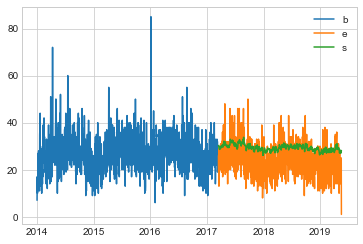

In [35]:
#for plotting
train = new_data[:1169]
valid = new_data[1169:]
valid['Predictions'] = crime_pred
plt.plot(train['total'])
plt.plot(valid[['total','Predictions']])
plt.legend('best')


This is a good fit but lets see if we use the rolling mean we can get a better fit

In [36]:
new_data = t.iloc[99:]
new_data = new_data[['REPORTED_DATE','RollingMean']]
new_data.head()

OFFENSE_TYPE_ID,REPORTED_DATE,RollingMean
99,2014-04-11,23.99
100,2014-04-12,24.64
101,2014-04-13,24.73
102,2014-04-14,24.92
103,2014-04-15,25.10


In [37]:
#setting index
new_data.index = new_data.REPORTED_DATE
new_data.drop('REPORTED_DATE', axis=1, inplace=True)

#creating train and test sets

dataset = new_data.values
train = dataset[0:1169,:]
valid = dataset[1169:,:]

In [38]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [39]:


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting values, using past 160 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
crime_pred = model.predict(X_test)
crime_pred = scaler.inverse_transform(crime_pred)

Epoch 1/1
 - 115s - loss: 0.0026


In [40]:
rms=np.sqrt(np.mean(np.power((valid-crime_pred),2)))
rms

0.19256771691269117

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


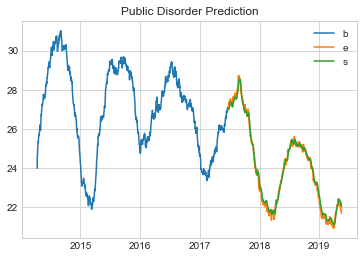

In [41]:
#for plotting
train = new_data[:1169]
valid = new_data[1169:]
valid['Predictions'] = crime_pred
plt.plot(train['RollingMean'])
plt.plot(valid[['RollingMean','Predictions']])
plt.title('Public Disorder Prediction')
plt.legend('best')


Thats starting to looks a lot better and might all into overfitting but forcasting/predicting crime rates is extremely hard bc crime can be effected by so many outside influences.

# LSTM For Sexual Assualts

In [42]:
new_data = s.iloc[99:]
new_data = new_data[['REPORTED_DATE','RollingMean']]
new_data.head()

OFFENSE_TYPE_ID,REPORTED_DATE,RollingMean
99,2014-06-02,1.72
100,2014-06-03,1.72
101,2014-06-05,1.73
102,2014-06-07,1.73
103,2014-06-08,1.73


In [43]:
new_data = s.iloc[99:]
new_data = new_data[['REPORTED_DATE','RollingMean']]
new_data.head()

OFFENSE_TYPE_ID,REPORTED_DATE,RollingMean
99,2014-06-02,1.72
100,2014-06-03,1.72
101,2014-06-05,1.73
102,2014-06-07,1.73
103,2014-06-08,1.73


In [44]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [45]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)

#predicting values, using past 160 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
crime_pred = model.predict(X_test)
crime_pred = scaler.inverse_transform(crime_pred)

Epoch 1/2
 - 115s - loss: 0.0037
Epoch 2/2
 - 113s - loss: 8.2023e-04


TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-crime_pred),2)))
rms

In [ ]:
#for plotting
train = new_data[:1169]
valid = new_data[1169:]
valid['Predictions'] = crime_pred
plt.plot(train['RollingMean'])
plt.plot(valid[['RollingMean','Predictions']])
plt.title('Sexual Assault Prediction')
plt.legend('best')
